In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt 
from numpy.linalg import cholesky
from scipy.stats import norm
import scipy.stats as sc
import scipy
from tabulate import tabulate
import pandas as pd

# Exercise 1
### 1.4

In [2]:
def Asian_Call_MC_BS(S0, K, r, T, sigma, N, n):
    #S0 spot price
    #K strike
    #r interest rate
    #T maturity
    #N the sample size of Monte Carlo
    #n step number of the uniform time grid
    
    G = npr.normal(size=(N,n)) #to create Gaussian variables
    step=T/n #uniform time grid
    
    Log_returns=(r-sigma**2/2)*step + sigma *np.sqrt(step)*G
    Log_returns_0=np.concatenate((np.ones((N,1))*np.log(S0),Log_returns), axis=1)
    Log_path=np.cumsum(Log_returns_0,axis=1)
    S_path=np.exp(Log_path)
    
    
    S_bar=np.mean(S_path[:,:n],axis=1) # vector of n independent copies of the Riemann approximation of the integral
    
    #payoff w/o control variates
    payoff=np.exp(-r*T)*np.maximum(S_bar-K,0)
    
    #calculate control variate (CV1) or Y and its expected value with explicit formula
    integral = np.sum(Log_path[:, 1:], axis = 1)/n
    Y = np.exp(-r*T) * np.sum(Log_path[:,:n],axis=1)/n
    #E_Y = S0*np.exp((r+sigma**2/6)*-T/2)
    CV1 = np.cov(payoff,Y)[0,1]/np.var(Y)
    coefficient_Y=np.cov(payoff,Y)[0,1]/np.var(Y)

    #calculate control variate (CV2) or Z and its expected value with explicit
    
    d2= 1/(sigma*np.sqrt(T/3))*(np.log(S0/K)+(r/2-sigma**2/4)*T)
    d1= 1/(sigma*np.sqrt(T/3))*(np.log(S0/K)+(r/2-sigma**2/4)*T)+sigma*np.sqrt(T/3)
    Z = np.exp(-r*T) * np.maximum(np.exp(integral)-K,0)
    #E_Z = S0*np.exp((r+sigma**2/6)*-T/2)*cdf(d1)-K*np.exp(-r*T)*cdf(d2)
    CV2 = np.cov(payoff,Z)[0,1]/np.var(Z)
    coefficient_Z=np.cov(payoff,Z)[0,1]/np.var(Z)
    
    #payoff w/ control variate CV1
    payoff_CV1=payoff-coefficient_Y*(Y-np.mean(Y))
    #payoff w/ control variate CV2
    payoff_CV2=payoff-coefficient_Z*(Z-np.mean(Z))
    
    # Monte Carlo results
    MC_price=np.mean(payoff)
    MC_price_CV1=np.mean(payoff_CV1)
    MC_price_CV2=np.mean(payoff_CV2)
    
    #Error
    MC_var=np.var(payoff)#1.96*np.std(payoff)/np.sqrt(N)
    MC_var_CV1=np.var(payoff_CV1)#1.96*np.std(payoff_CV1)/np.sqrt(N)
    MC_var_CV2=np.var(payoff_CV2)#1.96*np.std(payoff_CV2)/np.sqrt(N)
    
    #Confidence intervals
    MC_UP=np.mean(payoff)+1.96*np.std(payoff)/np.sqrt(N)
    MC_DOWN=np.mean(payoff)-1.96*np.std(payoff)/np.sqrt(N)
    MC_CV1_UP=np.mean(MC_price_CV1)+1.96*np.std(payoff_CV1)/np.sqrt(N)
    MC_CV1_DOWN=np.mean(MC_price_CV1)-1.96*np.std(payoff_CV1)/np.sqrt(N)
    MC_UP=np.mean(MC_price_CV2)+1.96*np.std(payoff_CV2)/np.sqrt(N)
    MC_DOWN=np.mean(MC_price_CV2)-1.96*np.std(payoff_CV2)/np.sqrt(N)
    
    
    return MC_price, MC_var, MC_UP, MC_DOWN, MC_price_CV1, MC_var_CV1, MC_CV1_UP, MC_CV1_DOWN, MC_price_CV2, MC_var_CV2, MC_UP, MC_DOWN

In [3]:
S0 = 100
K = 100
r = 0.04
T = 1
sigma = 0.2
N = 100000
n = 365

Results = Asian_Call_MC_BS(S0, K, r, T, sigma, N, n)
MC = Results[0:4]
MC_CV1 = Results[4:8]
MC_CV2 = Results[8:12]

print(f'Price with MC: {MC[0]} | Variance: {MC[1]}')
print(f'Price with Control Variate Y: {MC_CV1[0]} | Variance: {MC_CV1[1]}')
print(f'Price with Control Variate Z: {MC_CV2[0]} | Variance: {MC_CV2[1]}\n\n')

print(tabulate([list(MC), list(MC_CV1), list(MC_CV2)], headers=['Price','Error','CI_UP','CI_DOWN'], tablefmt='orgtbl'))

Price with MC: 5.536523759544286 | Variance: 61.766818409749
Price with Control Variate Y: 5.536523759544343 | Variance: 15.708832678906985
Price with Control Variate Z: 5.536523759544286 | Variance: 0.04178740692359711


|   Price |      Error |   CI_UP |   CI_DOWN |
|---------+------------+---------+-----------|
| 5.53652 | 61.7668    | 5.53779 |   5.53526 |
| 5.53652 | 15.7088    | 5.56109 |   5.51196 |
| 5.53652 |  0.0417874 | 5.53779 |   5.53526 |


### 1.5

In [4]:
def Vega_Asian_Option(S0, K, r, T, sigma, n, N):
    #S0 spot price
    #K strike
    #r interest rate
    #T maturity
    #N the sample size of Monte Carlo
    #n step number of the uniform time grid
    dt = T / N #time grid
    St = S0 * np.ones((n, N))
    
    #init
    PathWiseDerivatives = np.zeros((n, N))
    LogLikelihoodRatio = np.zeros(n)
    
    for j in range(1, N):
        tj = j * dt
        Z = np.random.normal(size=n)
        St[:, j] = St[:, j-1] * np.exp((r - 0.5 * sigma**2) * (dt) + sigma * np.sqrt(dt) * Z)
        PathWiseDerivatives[:, j] = St[:, j] * [1 if x > K else 0 for x in St[:, j]] *  ( ( np.log(St[:, j] / St[:, 0]) - (r + sigma**2/2) * tj ) / sigma )
        LogLikelihoodRatio += (Z**2 - 1) / sigma - Z * np.sqrt(dt)
    meanPathWiseDerivatives = np.mean(PathWiseDerivatives, axis=1)
    meanSt = np.mean(St, axis=1)
    payoff_likelihood = list(map(lambda x: max(x - K, 0), meanSt)) * LogLikelihoodRatio
    payoff_pathwise = list(map(lambda x: 1 if x > K else 0, meanSt)) * meanPathWiseDerivatives
    vega_pathwise = np.exp(-r * T) * payoff_pathwise
    vega_likelihood = np.exp(-r * T) * payoff_likelihood
    return np.mean(vega_pathwise), 1.96 * np.std(vega_pathwise) / np.sqrt(N), np.mean(vega_likelihood), 1.96 * np.std(vega_likelihood) / np.sqrt(N)

In [5]:
S0 = 100
K = 100
r = 0.04
T = 1
sigma = 0.2
n = 100000
N = 20
PW_Vega, PW_Error, LL_Vega, LL_Error = Vega_Asian_Option(S0, K, r, T, sigma, n, N)

print(f'Vega with path-wise derivative: {PW_Vega} | Error: {PW_Error}')
print(f'Vega with log-Likelihood: {LL_Vega} | Error: {LL_Error}\n')

print(tabulate([list(['Path-Wise', PW_Vega, PW_Error]), list(['Log-Likelihood', LL_Vega, LL_Error])], headers=['Method', 'Vega','Error'], tablefmt="grid"))

Vega with path-wise derivative: 23.601242094811727 | Error: 16.24362464487452
Vega with log-Likelihood: 20.626133004555392 | Error: 135.99736307962758

+----------------+---------+----------+
| Method         |    Vega |    Error |
+================+=========+==========+
| Path-Wise      | 23.6012 |  16.2436 |
+----------------+---------+----------+
| Log-Likelihood | 20.6261 | 135.997  |
+----------------+---------+----------+


# Exercice 2
### 2.2

In [6]:
def MC_Delayed_European(S0, sigma, r, T, t1, lam, N):
    #S0 spot price
    #K Strike
    #r interest rate
    #t1 delayed start time
    #T time to maturity
    #sigma annualized volatility
    #lam lambda
    #N sample size
    payoffs = np.zeros(N)
    for j in range(0, N):
        Z1 = np.random.normal(0,1)
        S_t1 = S0 * np.exp( (r - sigma**2/2)*t1 + sigma*np.sqrt(t1)*Z1 )
        K = lam * S_t1
        
        Z2 = np.random.normal(0,1)
        S_t2 = S_t1 * np.exp( (r - sigma**2/2)*(T-t1) + sigma*np.sqrt(T-t1)*Z2 )
        
        payoffs[j] = np.maximum(S_t2 - K, 0) * np.exp(-r * T)
    
    payoff = np.mean(payoffs)
    MC_error_call = 1.96 * np.std(payoffs) / np.sqrt(N)
    CI_UP = payoff + 1.96 * np.std(payoff) / np.sqrt(N)
    CI_DOWN = payoff - 1.96 * np.std(payoff) / np.sqrt(N)
        
    return payoff, MC_error_call, CI_UP, CI_DOWN

In [7]:
def European_Call_BS(S, K, sigma, r, T, t1):
    d1 = 1 / (sigma*np.sqrt(T-t1)) * ( np.log(S/K) + (r + sigma**2/2) * (T-t1) )
    d2 = 1 / (sigma*np.sqrt(T-t1)) * ( np.log(S/K) + (r - sigma**2/2) * (T-t1) )

    true_price = S * sc.norm.cdf(d1) - K * sc.norm.cdf(d2) * np.exp(-r * (T-t1) )

    return true_price

In [8]:
def MC_Cond_Delayed_European(S0, sigma, r, T, t1, lam, N):
    #S0 spot price
    #K Strike
    #r interest rate
    #t1 delayed start time
    #T time to maturity
    #sigma annualized volatility
    #lam lambda
    #N sample size

    payoffs = np.zeros(N)
    for j in range(0, N):
        Z1 = np.random.normal(0,1)
        S_t1 = S0 * np.exp( (r - sigma**2/2)*t1 + sigma*np.sqrt(t1)*Z1 )
        K = lam * S_t1
        
        payoffs[j] = np.exp(-r * t1) * European_Call_BS(S_t1, K, sigma, r, T, t1)
        
    payoff = np.mean(payoffs)
    MC_error_call = 1.96 * np.std(payoffs) / np.sqrt(N)
    CI_UP = payoff + 1.96 * np.std(payoff) / np.sqrt(N)
    CI_DOWN = payoff - 1.96 * np.std(payoff) / np.sqrt(N)
    
    return payoff, MC_error_call, CI_UP, CI_DOWN

In [9]:
S0 = 100
r = 0.05
T = 4
t1 = T/4
sigma = 0.3
lam = 0.9
N = 100000

Algo1 = MC_Delayed_European(S0, sigma, r, T, t1, lam, N)
Algo2 = MC_Cond_Delayed_European(S0, sigma, r, T, t1, lam, N)
BS = S0 * European_Call_BS(1, lam, sigma, r, T, t1)

print(f'Price with algorithm 1: {Algo1[0]} | Error: {Algo1[1]} | CI_UP: {Algo1[2]} - CI_DOWN: {Algo1[3]}\n')
print(f'Price with algorithm 2: {Algo2[0]} | Error: {Algo2[1]} | CI_UP: {Algo2[2]} - CI_DOWN: {Algo2[3]}\n')
print(f'Price with Black Scholes: {BS}\n')

print(tabulate([['Algorithm 1'] + list(Algo1), ['Algorithm 2'] + list(Algo2), ['Explicit formula (BS)'] + list([BS,'#','#','#'])], headers=['Method', 'Price','Error','CI_UP','CI_DOWN'], tablefmt='github'))

Price with algorithm 1: 31.463686410222834 | Error: 0.31754686053427605 | CI_UP: 31.463686410222834 - CI_DOWN: 31.463686410222834

Price with algorithm 2: 31.49208737850672 | Error: 0.059982168912944264 | CI_UP: 31.49208737850672 - CI_DOWN: 31.49208737850672

Price with Black Scholes: 31.548194619572513

| Method                |   Price | Error                | CI_UP              | CI_DOWN            |
|-----------------------|---------|----------------------|--------------------|--------------------|
| Algorithm 1           | 31.4637 | 0.31754686053427605  | 31.463686410222834 | 31.463686410222834 |
| Algorithm 2           | 31.4921 | 0.059982168912944264 | 31.49208737850672  | 31.49208737850672  |
| Explicit formula (BS) | 31.5482 | #                    | #                  | #                  |


# Exercise 3
### 3.1

In [10]:
regression_basis = {
    0: lambda X: np.array(X**0).reshape(-1, 1),
    1: lambda X: np.column_stack((np.ones_like(X), 1 - X)),
    2: lambda X: np.column_stack((np.ones_like(X), 1 - X, 0.5 * (2 - 4 * X + X**2))),
    3: lambda X: np.column_stack((np.ones_like(X), 1 - X, 0.5 * (2 - 4 * X + X**2), 1/6 * (6 - 18 * X + 9 * X**2 - X**3))),
}

def Longstaff_Schwartz_Algorithm(S0, K, r, T, N, n, basis_size):
    #S0 spot price
    #K Strike
    #r interest rate
    #T time to maturity
    #sigma vol
    #N sample size
    dt = T / n # uniform time grid
    G = np.random.normal(size=(N, n))
    Log_returns = (r - sigma**2/2)*dt + sigma*np.sqrt(dt)*G
    Log_returns_0 = np.concatenate((np.ones((N,1))*np.log(S0), Log_returns), axis = 1) 
    Log_path = np.cumsum(Log_returns_0, axis = 1)
    Spath = np.exp(Log_path)
    discountVect = (np.exp(-r*dt*np.arange(1,n+1,1)))
    exercise_boundary = [K]


    CashFlow = np.maximum(0, K-Spath[:, -1])
    for i in range(n-1, -1, -1): #backward loop
        index_in_money = np.maximum(0,K-Spath[:, i]) > 0 
        X = Spath[index_in_money, i] #Consider only the in-money paths, like in-class example
        XData = np.vstack(regression_basis[basis_size](X))

        YData = discountVect[0] * CashFlow[index_in_money]
        alpha = np.linalg.lstsq(XData, YData, rcond = -1)[0]  #Linear matrix equation [0] for coeffs

        ContinuationValue = XData @ alpha
        index_Exercise = np.maximum(0,K-X)
        #update cash flow
        CashFlow[index_in_money] = np.where(index_Exercise >= ContinuationValue, index_Exercise, CashFlow[index_in_money]* discountVect[0])

        if (basis_size == 3) & (len(X[index_Exercise >= ContinuationValue]) > 0): 
            exercise_boundary.append(np.max(X[index_Exercise >= ContinuationValue]))

        LS_payoff = discountVect[0] * ( np.sum(CashFlow[:,]) / N )
        LS_error = np.std(discountVect[0] * CashFlow ) / np.sqrt(N) 
        CI_UP, CI_DOWN = LS_payoff + 1.96 * LS_error, LS_payoff - 1.96 * LS_error

    return LS_payoff, LS_error, CI_UP, CI_DOWN, exercise_boundary

In [11]:
S0 = 90
K = 100
r = 0.03
sigma = 0.2 
T=1
n = 75
N = 75000
bounds = []
df = pd.DataFrame()
for b_size in regression_basis.keys():
    Results = Longstaff_Schwartz_Algorithm(S0, K, r, T, N, n, b_size)
    df[b_size] = Results[:4]
    bounds.append(Results[4])

bounds = bounds[3:][0]

print(tabulate(df.T, headers=['Basis Size', 'Price','Error','CI_UP','CI_DOWN'], tablefmt='orgtbl'))

|   Basis Size |   Price |     Error |   CI_UP |   CI_DOWN |
|--------------+---------+-----------+---------+-----------|
|            0 | 11.2722 | 0.0175657 | 11.3066 |   11.2378 |
|            1 | 12.0203 | 0.0330978 | 12.0851 |   11.9554 |
|            2 | 12.1602 | 0.0317252 | 12.2223 |   12.098  |
|            3 | 12.1859 | 0.0318227 | 12.2483 |   12.1236 |


## 3.2

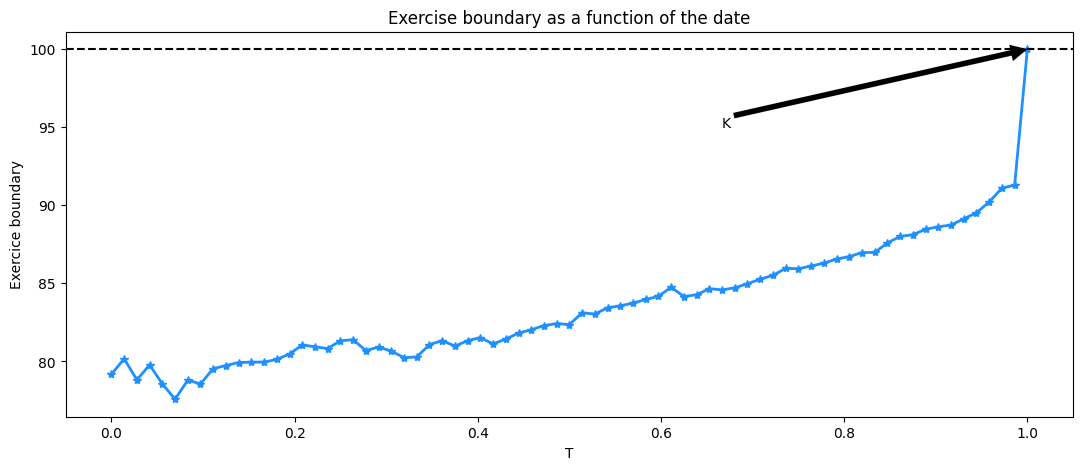

In [12]:
x = np.linspace(0,T,len(bounds))
y = np.flip(bounds)

plt.figure(figsize=(13,5))
plt.plot(x,y, color='dodgerblue', marker='*', lw=2)
plt.axhline(K, color='black', ls='--')
plt.xlabel('T')
plt.ylabel('Exercice boundary')
middle_x = 2*x[len(x) // 3]
plt.annotate("K", xy=(1, K), xytext=(middle_x, K*0.95),
             arrowprops=dict(facecolor='black', lw=.05,  linestyle='dotted'))
plt.title('Exercise boundary as a function of the date')
plt.show()

## 3.3

In [13]:
def SimulateHedging(S0, K, T, r, sigma, nPeriods, nSim):
    dt = T/nPeriods
    
    #simulate random price of an asset
    G = np.random.normal(size=(1,nPeriods))
    step = T/n #uniform timegrid
    log_returns = (r-sigma**2 / 2) * step + sigma * np.sqrt(step) * G
    log_returns = np.concatenate( (np.ones((1,1))*np.log(S0), log_returns), axis=1 )
    log_path = np.cumsum(log_returns, axis=1)
    S_path = np.exp(log_path) #spot price of the asset along nPeriods of hedging
    
    Deltas = np.zeros(nPeriods)
    Prices = np.zeros(nPeriods)
    Prices[0] = Longstaff_Schwartz_Algorithm(S0, K, r, T, nSim, 1000, basis_size=3)[0]
    
    h=1e-2
    
    for period in range(1,nPeriods):
        Spot = S_path[:,period] #Spot at period
        Price_plus_H = Longstaff_Schwartz_Algorithm(Spot+h, K, r, (T-period*dt), nSim, 1000, basis_size=3)[0]
        Price_minus_H = Longstaff_Schwartz_Algorithm(Spot-h, K, r, (T-period*dt), nSim, 1000, basis_size=3)[0] 

        Delta_new = (Price_plus_H - Price_minus_H) / (h*2)
        
        Price_new = Longstaff_Schwartz_Algorithm(Spot, K, r, (T-period*dt), nSim, n, basis_size=3)[0]

        Deltas[period] = Delta_new
        Prices[period] = Price_new
        #print(Delta_new)
        #print(Price_new)
    return Deltas, Prices, S_path

Deltas, Prices, Spots = SimulateHedging(90,100,1,0.04,0.2,100,100)

pnl = np.diff(-Deltas) * np.diff(Spots[0][:-1])

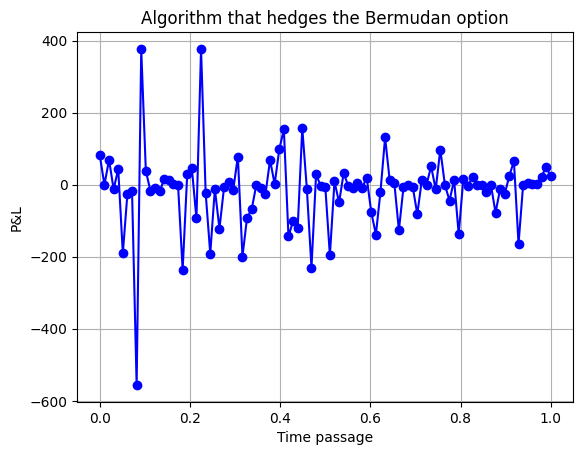

In [14]:
t_plot = np.linspace(0, T, len(pnl))
plt.plot(t_plot, pnl, marker='o', linestyle='-', color='b') 
plt.xlabel('Time passage')
plt.ylabel('P&L')
plt.title('Algorithm that hedges the Bermudan option')
plt.grid(True)
plt.show()